In [5]:
import math

from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMTGate, MCMT, XGate, ZGate
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [7]:
oracle = QuantumCircuit(4, name="oracle")
oracle.x(2)
oracle.x(1)
oracle.compose(MCMTGate(ZGate(), 3, 1, ctrl_state=None, label=None), inplace=True)

oracle.x(2)
oracle.x(1)

oracle.draw()

1-Z      
q_0: ───────■───────
     ┌───┐  │  ┌───┐
q_1: ┤ X ├──■──┤ X ├
     ├───┤  │  ├───┤
q_2: ┤ X ├──■──┤ X ├
     └───┘  │  └───┘
q_3: ───────■───────

Let's see how this oracle works by applying it to the state we look for and some other state.
We look for state 1001, so let's start with it first:

In [11]:
from qiskit.quantum_info import Statevector

state = Statevector.from_label('1001')
state = state.evolve(oracle)
state.draw('latex')

<IPython.core.display.Latex object>

It was correctly multiplied by -1. - as we need.
Now let's show that it leaves other states untached, let's use 1011 as an example, but you can experiment with any state:

In [12]:
state = Statevector.from_label('1011')
state = state.evolve(oracle)
state.draw('latex')

<IPython.core.display.Latex object>

In [13]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

C:\Users\P39686820\AppData\Local\Temp\ipykernel_10348\2758857765.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(channel="ibm_quantum")


'ibm_sherbrooke'

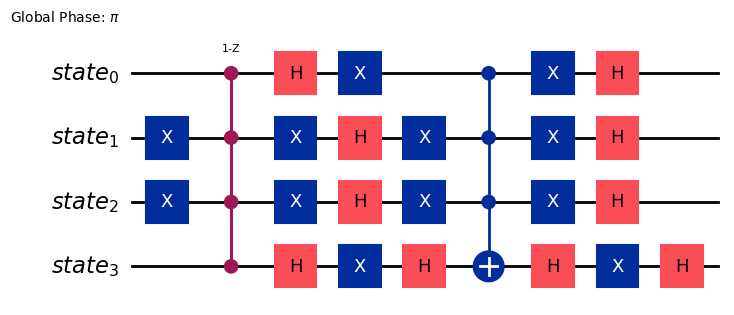

In [14]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [15]:
optimal_num_iterations = math.floor(math.pi / (4 * math.asin(math.sqrt(1 / 2**grover_op.num_qubits))))
print(optimal_num_iterations)

3


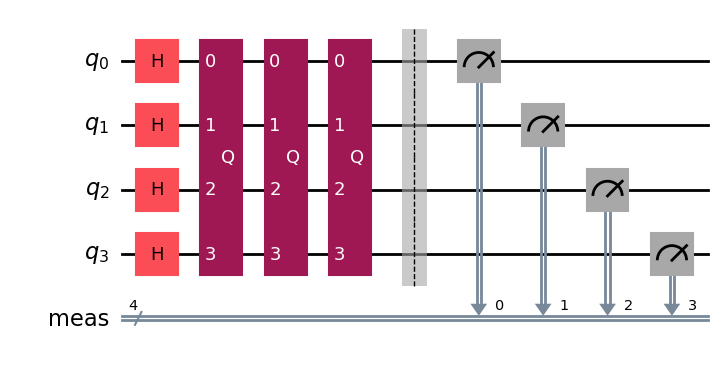

In [16]:
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")

In [31]:
from qiskit.primitives import StatevectorSampler

sampler_simulator = StatevectorSampler()

num_shots = 1000000
pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit_simulator = pm.run(qc)
result = sampler_simulator.run([isa_circuit_simulator], shots=num_shots).result()
data_pub = result[0].data
counts = data_pub.meas.get_counts()

for i in counts:
    counts[i] = float(counts[i]/num_shots)

print(f"The probabilities are: {counts}")

The probabilities are: {'1001': 0.961159, '1010': 0.002669, '1110': 0.00271, '0000': 0.002491, '0010': 0.002623, '1100': 0.002581, '0001': 0.002546, '1101': 0.002623, '1111': 0.002551, '0110': 0.0026, '1011': 0.002596, '0111': 0.002584, '0011': 0.002563, '0101': 0.002557, '1000': 0.002557, '0100': 0.00259}


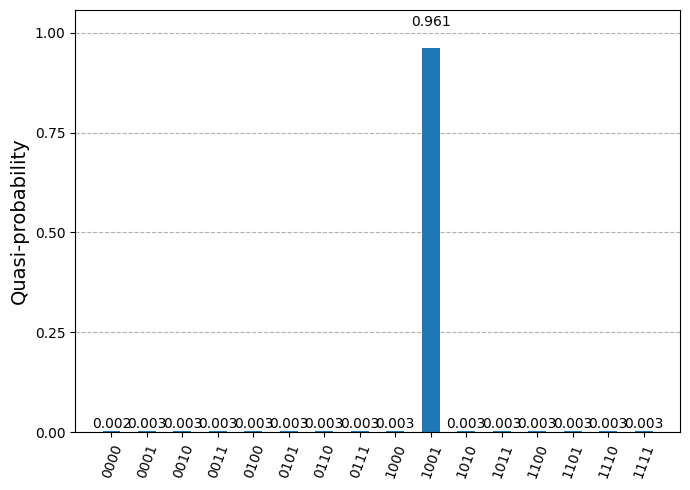

In [32]:
plot_distribution(counts)

much better :)

# Exercise 0
Play with number of Grover operator iterations. Go from 1 to 6 iterations. Explain the results.

# Exercise 1
Implement Grover search on real backend, but with 3 qubits, looking for state |110>. Optimize for proper state amplification.

# Exercise 2
Implement Grover search algorithm in simulator, looking for state |00111>

# Exercise 3
Implement phone book search example using Grover algorithm. Use simulator to run it.\
Each basis state has person name assigned. Look for particular name, having just the number (basis state).\
Implementation should be generic, allowing to use arbitrary number of qubit (quantity of phone numbers).